In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
column_names = []

with open("data\\breast-cancer.labels") as f:
    for line in f.readlines():
        column_names.append(line[:(len(line))-1])

In [3]:
breast_cancer_train = pd.io.parsers.read_csv("data\\breast-cancer-train.dat")
breast_cancer_train.columns = column_names

breast_cancer_validate =  pd.io.parsers.read_csv("data\\breast-cancer-validate.dat")
breast_cancer_validate.columns = column_names

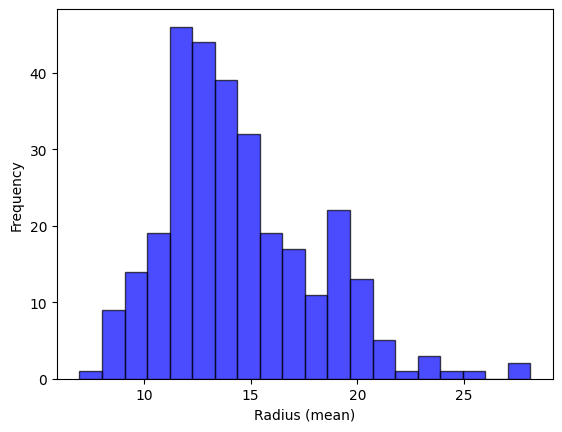

In [4]:
plt.hist(breast_cancer_train["radius (mean)"],bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.ylabel("Frequency")
plt.xlabel("Radius (mean)")
plt.show()

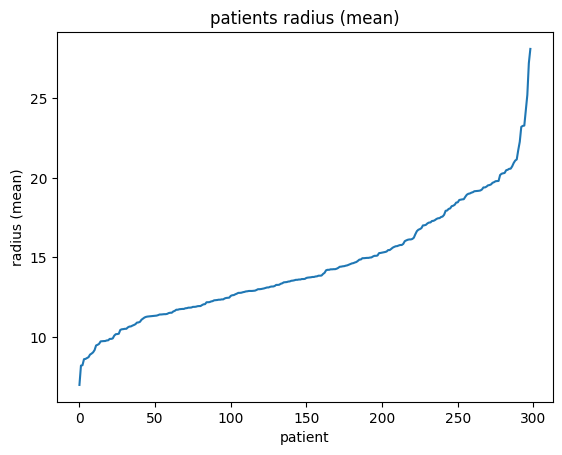

In [5]:
plt.plot(breast_cancer_train["radius (mean)"].sort_values(ignore_index=True))
plt.title("patients radius (mean)")
plt.xlabel("patient")
plt.ylabel("radius (mean)")
plt.show()

In [6]:
# Train
# Lin
A_lin_train = breast_cancer_train.drop("Malignant/Benign", axis=1).to_numpy()
# A_lin_train = np.column_stack((np.ones(A_lin_train.shape[0]), A_lin_train))
# Quad
A_quad_train = breast_cancer_train[["radius (mean)", "perimeter (mean)", "area (mean)", "symmetry (mean)"]].to_numpy()
A_quad_train = np.column_stack((A_quad_train, A_quad_train**2, [[a*b for a,b in list(combinations(row, 2))] for row in A_quad_train]))


# Validate
# Lin
A_lin_validate = breast_cancer_validate.drop("Malignant/Benign", axis=1).to_numpy()
# A_lin_validate = np.column_stack((np.ones(A_lin_validate.shape[0]), A_lin_validate))
# Quad
A_quad_validate = breast_cancer_validate[["radius (mean)", "perimeter (mean)", "area (mean)", "symmetry (mean)"]].to_numpy()
A_quad_validate = np.column_stack((A_quad_validate, A_quad_validate**2, [[a*b for a,b in list(combinations(row, 2))] for row in A_quad_validate]))

In [7]:
b_train = np.where(breast_cancer_train['Malignant/Benign'] == 'M', 1, -1)
b_validate = np.where(breast_cancer_validate['Malignant/Benign'] == 'M', 1, -1)

In [8]:
# Liniowa
w_lin = np.linalg.solve(A_lin_train.T @ A_lin_train, A_lin_train.T @ b_train)
# Kwadratowa
w_quad = np.linalg.solve(A_quad_train.T @ A_quad_train, A_quad_train.T @ b_train)

In [9]:
cond_lin = (np.linalg.cond(A_lin_train))**2
cond_quad = (np.linalg.cond(A_quad_train))**2

cond_fact_lin = np.linalg.norm(A_lin_train.T) * np.linalg.norm(A_lin_train)
cond_fact_quad = np.linalg.norm(A_quad_train.T) * np.linalg.norm(A_quad_train)

In [10]:
# Liniowa
p_lin = A_lin_validate @ w_lin
p_lin = np.where(p_lin > 0, 1, -1)

# Kwadratowa
p_quad = A_quad_validate @ w_quad
p_quad = np.where(p_quad > 0, 1, -1)


In [11]:
# Liniowa
false_positives_lin = np.sum(np.logical_and(p_lin > 0, b_validate < 0))
false_negatives_lin = np.sum(np.logical_and(p_lin < 0, b_validate > 0))
lin_malignant = np.sum(np.where(p_lin > 0, 1, 0))
lin_benign = np.sum(np.where(p_lin <= 0, 1, 0))

# Kwadratowa
false_positives_quad = np.sum(np.logical_and(p_quad > 0, b_validate < 0))
false_negatives_quad = np.sum(np.logical_and(p_quad < 0, b_validate > 0))
quad_malignant = np.sum(np.where(p_quad > 0, 1, 0))
quad_benign = np.sum(np.where(p_quad <= 0, 1, 0))

df = pd.DataFrame({
    "Liczba fałszywie ujemnych": [false_negatives_lin, false_negatives_quad],
    "Liczba fałszywie dodatnich": [false_positives_lin, false_positives_quad],
    "Liczba przewidzianych nowotworów złośliwych": [lin_malignant, quad_malignant],
    "Liczba przewidzianych nowotworów łagodnych": [lin_benign, quad_benign],
    "Dokładność": [(lin_malignant-false_negatives_lin+lin_benign-false_positives_lin)/(lin_malignant+lin_benign), (quad_malignant-false_negatives_quad+quad_benign-false_positives_quad)/(quad_malignant+quad_benign)],
})\
    .style.relabel_index(["Reprezentacja liniowa", "Reprezentacja najmnieszych kwadratów"], axis=0)

print(df.to_latex())

\begin{tabular}{lrrrrr}
 & Liczba fałszywie ujemnych & Liczba fałszywie dodatnich & Liczba przewidzianych nowotworów złośliwych & Liczba przewidzianych nowotworów łagodnych & Dokładność \\
Reprezentacja liniowa & 2 & 6 & 63 & 196 & 0.969112 \\
Reprezentacja najmnieszych kwadratów & 5 & 15 & 69 & 190 & 0.922780 \\
\end{tabular}

